## Understanding the CVEs within existing Docker Images

In [1]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

In [2]:
# Get the outputs from the Grype scans
grype_results = os.listdir("./../grype-output/")

# Sort the filenames
grype_results.sort()

# image names
images = list(set([x.split('-')[0] for x in grype_results]))

# Create a dictionary to hold results
results = dict()
vulns = pd.DataFrame()

# Load each Grype Scan
for file in grype_results:
    with open(f'./../grype-output/{file}') as f:
        # Load the json data
        grype_data = json.load(f)

        # Append results to dictionary
        results[f"{file.replace('.json', '')}"] = len(grype_data['matches'])

        # Create a list of all the vulns within the image
        temp_vuln = [[file.replace('-grype.json', ''), 
                        x['vulnerability']['id'], 
                        x['vulnerability']['severity'], 
                        x['artifact']['name'], 
                        x['artifact']['version'], 
                        x['artifact']['type']] for x in grype_data['matches']]
        
        # Create a temp DF to hold vuln data
        temp_vuln_df = pd.DataFrame(temp_vuln, columns = ['image', 'vuln_id', 'severity', 'name', 'version', 'type'])

        # Set the image type (original/updated/cg (chainguard))
        if "-updated" in file:
            temp_vuln_df['image_type'] = "updated"
        elif "-cg" in file:
            temp_vuln_df['image_type'] = "cg"
        else:
            temp_vuln_df['image_type'] = "original"

        # Concat the version data back to the complete version DF
        vulns = pd.concat([vulns, temp_vuln_df])

# create a dict and DF to hold SBOM and versions data
sboms = dict()
versions = pd.DataFrame()

# Load each SBOM
for file in os.listdir("./../syft-output/"):
    with open(f'./../syft-output/{file}') as f:
        # Load the json data
        sbom = json.load(f)

        # Append results to dictionary
        sboms[f"{file.replace('.json', '')}"] = len(sbom['artifacts'])

        # Create a list of all the packages within the image
        temp_ver = [[file.replace('-sbom.json', ''), 
                        x['id'], 
                        x['name'], 
                        x['version'], 
                        x['type']] for x in sbom['artifacts']]
        # Create a temp DF to hold data
        temp_ver_df = pd.DataFrame(temp_ver, columns = ['image', 'id', 'name', 'version', 'type'])

        # Set the image type (original/updated/cg (chainguard))
        if "-updated" in file:
            temp_ver_df['image_type'] = "updated"
        elif "-cg" in file:
            temp_ver_df['image_type'] = "cg"
        else:
            temp_ver_df['image_type'] = "original"

        # Concat the version data back to the complete version DF
        versions = pd.concat([versions, temp_ver_df])

## How many packages appear in an image?

We can see this from the SBOM

In [3]:
print(f"Unique Images: {len(images)}\n")
print(f"Packages per image: \n{versions[versions['image_type']=='original'].image.value_counts()}\n")
print(f"Package average: {versions[versions['image_type']=='original'].image.value_counts().mean()} ")

Unique Images: 10

Packages per image: 
image
node         667
python       435
traefik      300
php          175
mariadb      156
nginx        151
postgres     147
memcached    109
redis        108
rabbitmq     105
Name: count, dtype: int64

Package average: 235.3 


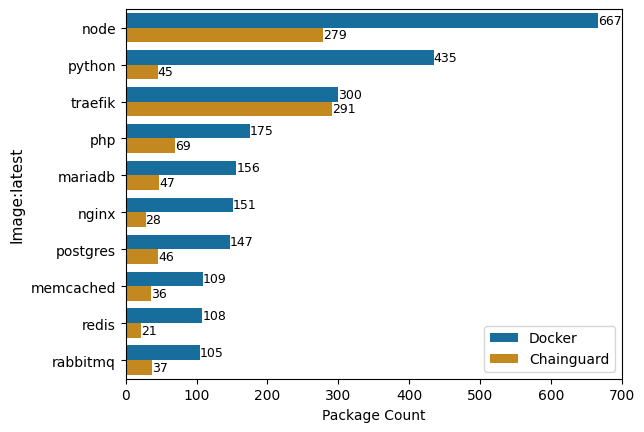

In [4]:
# generate package counts for original Docker image
packages = versions[(versions['image_type']=='original')&(versions['type']!="")].image.value_counts().reset_index(drop=False)
packages["image_type"] = "Docker"

# generate package counts for Chainguard image
cg_packages = versions[(versions['image_type']=='cg')&(versions['type']!="")].image.value_counts().reset_index(drop=False)
cg_packages["image_type"] = "Chainguard"
# Remove -cg from image so we can plot together
cg_packages['image'] = cg_packages.apply(lambda x: x['image'].replace("-cg", ""), axis=1)

# combine the packages to a single DF
combined_packages = pd.concat([packages, cg_packages]).reset_index(drop=True)

# generate the barplot
ax = sns.barplot(
    data=combined_packages, x="count", y="image", hue="image_type",
    palette="colorblind"
)

# Add package counts to each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=9)

# Set label size/location
ax.legend(loc='best', fontsize=10)

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Package Count', fontsize=10)
plt.show()

## What type of packages exist in the image?

### Docker

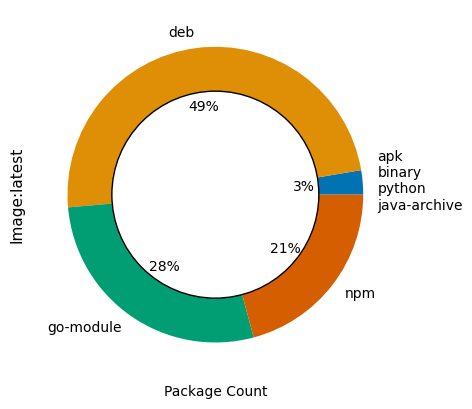

In [85]:
# generate package counts for original Docker image
packages_type = versions[(versions['image_type']=='original')&(versions['type']!="")].drop_duplicates(subset="name").type.value_counts().reset_index(drop=False)
packages_type["image_type"] = "Docker"

# create an other group
packages_type["label"] = packages_type.apply(
    lambda x: "apk\nbinary\npython\njava-archive" if x['type'] not in ['deb', 'go-module', 'npm'] else x['type'],
    axis=1
)

# condense package counts to only four labels ['deb', 'go-module', 'npm', 'other]
packages_type_condense = packages_type.groupby("label").sum("count").reset_index(drop=False)

# The slices will be ordered and plotted counter-clockwise.
labels = packages_type_condense["label"]
sizes = packages_type_condense["count"]
colors = sns.color_palette('colorblind')
explode = (0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=False)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.7,color='black', fc='white',linewidth=1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

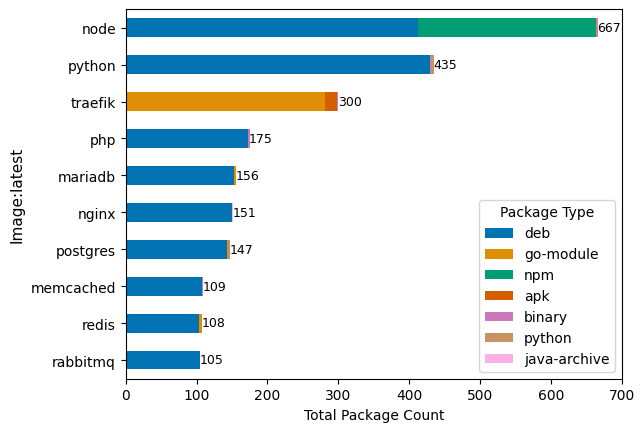

In [88]:
# generate package counts for original Docker image
pack_types = versions[(versions['image_type']=='original')&(versions['type']!="")].groupby(["type", "image"]).agg("count").reset_index(drop=False)

# pivot to make a clean DF
pack_types_pivot = pack_types.pivot(index='image', columns='type', values='id')

# set column order based on the most common types of packages
column_order = ['deb', 'go-module', 'npm', 'apk', 'binary', 'python', 'java-archive']

# Fille nans with 0
pack_types_pivot = pack_types_pivot.fillna(0)

# Create a totals package
pack_types_pivot['total'] = pack_types_pivot.sum(axis=1, numeric_only=True)

# sort by totals
pack_types_pivot = pack_types_pivot.sort_values("total")

# plot the stacked bar
ax = pack_types_pivot[column_order].plot(kind='barh', stacked=True, color=sns.color_palette('colorblind'))

# Add package counts to each bar
for i, total in enumerate(pack_types_pivot["total"].values.tolist()):
  ax.text(total+16, i-0.09, round(total),
          ha = 'center', color = 'black', fontsize='9')

ax.legend(title='Package Type')

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Total Package Count', fontsize=10)
plt.show()

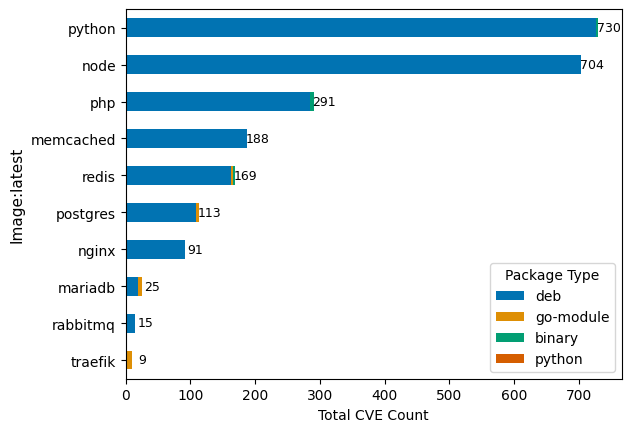

In [92]:
# generate package counts for original Docker image
vuln_types = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].groupby(["type", "image"]).agg("count").reset_index(drop=False)

# pivot to make a clean DF
vuln_types_pivot = vuln_types.pivot(index='image', columns='type', values='vuln_id')

# set column order based on the most common types of packages
column_order = ['deb', 'go-module', 'binary', 'python']

# Fille nans with 0
vuln_types_pivot = vuln_types_pivot.fillna(0)

# Create a totals package
vuln_types_pivot['total'] = vuln_types_pivot.sum(axis=1, numeric_only=True)

# sort by totals
vuln_types_pivot = vuln_types_pivot.sort_values("total")

# plot the stacked bar
ax = vuln_types_pivot[column_order].plot(kind='barh', stacked=True, color=sns.color_palette('colorblind'))

# Add package counts to each bar
for i, total in enumerate(vuln_types_pivot["total"].values.tolist()):
  ax.text(total+16, i-0.09, round(total),
          ha = 'center', color = 'black', fontsize='9')

ax.legend(title='Package Type')

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Total CVE Count', fontsize=10)
plt.show()

### Chainguard

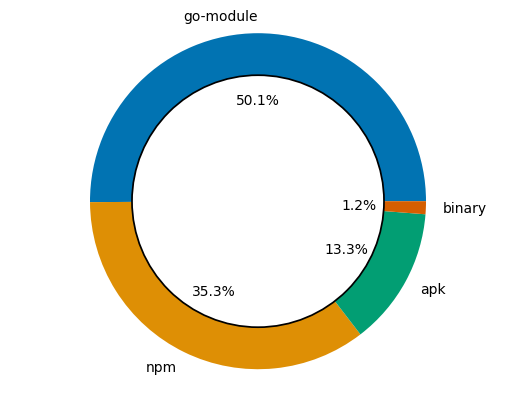

In [6]:
# generate package counts for Chainguard image
cg_packages_type = versions[(versions['image_type']=='cg')&(versions['type']!="")].drop_duplicates(subset="name").type.value_counts().reset_index(drop=False)
cg_packages_type["image_type"] = "Chainguard"

# The slices will be ordered and plotted counter-clockwise.
labels = cg_packages_type["type"]
sizes = cg_packages_type["count"]
colors = sns.color_palette('colorblind')
explode = (0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

## How many vulns appear per image?

In [7]:
print(f"Unique Images: {len(images)}\n")
print(f"Vulns per image: \n{vulns[vulns['image_type']=='original'].image.value_counts()}\n")
print(f"Unique CVEs")

Unique Images: 10

Vulns per image: 
image
python       730
node         704
php          291
memcached    188
redis        169
postgres     113
nginx         91
mariadb       25
rabbitmq      15
traefik        9
Name: count, dtype: int64

Unique CVEs


### What type of packages are these vulnerabilities appearing in? 

Majority of the vulnerabilities are appearing in Debian packages. So how do you update Debian packages?

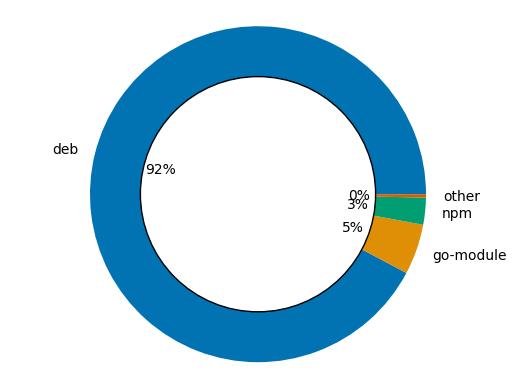

In [8]:
# generate package counts for original Docker image
# drop duplicates at the vuln-id/package type level. This is a distict count CVEs based on their respective package type. 
packages_vulns = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].drop_duplicates(subset=["vuln_id", "type"]).type.value_counts().reset_index(drop=False)
packages_vulns["image_type"] = "Docker"

# create an other group
# packages_vulns["label"] = packages_type.apply(
#     lambda x: "apk\nbinary\npython\njava-archive" if x['type'] not in ['deb', 'go-module', 'npm'] else x['type'],
#     axis=1
# )
packages_vulns["label"] = packages_type.apply(
    lambda x: "other" if x['type'] not in ['deb', 'go-module', 'npm'] else x['type'],
    axis=1
)

# condense package counts to only four labels ['deb', 'go-module', 'npm', 'other]
packages_vuln_condense = packages_vulns.groupby("label").sum("count").reset_index(drop=False)

# The slices will be ordered and plotted counter-clockwise.
labels = packages_vuln_condense["label"]
sizes = packages_vuln_condense["count"]
colors = sns.color_palette('colorblind')
explode = (0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=False)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.7,color='black', fc='white',linewidth=1)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

### CVE count for original Docker image and Updated Docker image

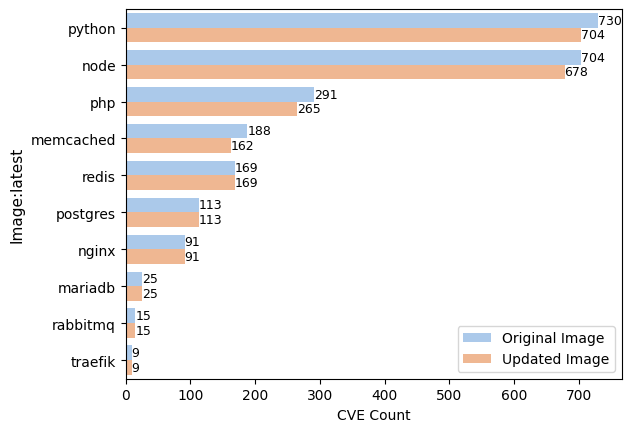

In [95]:
# generate package counts for original Docker image
packages = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
packages["image_type"] = "Original Image"

# generate package counts for Chainguard image
packages_updated = vulns[(vulns['image_type']=='updated')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
packages_updated["image_type"] = "Updated Image"
# Remove -cg from image so we can plot together
packages_updated['image'] = packages_updated.apply(lambda x: x['image'].replace("-updated", ""), axis=1)


# # generate package counts for Chainguard image
# packages_cg = vulns[(vulns['image_type']=='cg')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
# packages_cg["image_type"] = "Updated Image"
# # Remove -cg from image so we can plot together
# packages_cg['image'] = packages_updated.apply(lambda x: x['image'].replace("-updated", ""), axis=1)

# combine the packages to a single DF
combined_packages = pd.concat([packages, packages_updated]).reset_index(drop=True)

# generate the barplot
ax = sns.barplot(
    data=combined_packages, x="count", y="image", hue="image_type",
    palette="pastel"
)

# Add package counts to each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=9)

# Set label size/location
ax.legend(loc='best', fontsize=10)

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('CVE Count', fontsize=10)
plt.show()

In [ ]:
node = vulns[(vulns['image_type']=='original')&(vulns['image']=="node")]

In [ ]:
node.vuln_id.value_counts()

In [ ]:
node[node['vuln_id']=='CVE-2023-1906']

In [ ]:
node[["vuln_id", "name"]].value_counts()